In [2]:
import numpy as np
import scipy.ndimage
import scipy.optimize
import os, sys
import matplotlib.pyplot as plt
%matplotlib inline
import tifffile

In [120]:
if True:
    lensletSize = 24
    numLenslets = 16
else:
    lensletSize = 32
    numLenslets = 4
else:
    lensletSize = 4
    numLenslets = 32
    
imageSize = numLenslets * lensletSize
gaussianRadius = 30.0
dx = 20
dy = 10

trivial = False

In [201]:
def CircleMask(r, samples):
    cent = int(samples/2)
    y,x = np.ogrid[-cent:samples-cent, -cent:samples-cent]
    return (x*x + y*y <= r*r).astype(float)

def ForwardTransform(obj):
    # For an object, determine what the lenslet image is.
    # We break the object up into tiles and compute each subimage separately.
    # Because the object is an incoherent emitter, I think it is correct to treat each point separately/incoherently.
    # The result is actually very simple I think (for a source in the native focal plane):
    # just a uniform intensity within the lenslet footprint!
    if trivial:
        return obj
    result = np.zeros(obj.shape)
    footprint = np.ones((lensletSize, lensletSize))#CircleMask(lensletSize/2, lensletSize)
    footprintNorm = footprint / np.sum(footprint)
    for j in range(numLenslets):
        for i in range(numLenslets):
            pupil = obj[j*lensletSize:(j+1)*lensletSize, i*lensletSize:(i+1)*lensletSize]
            # Some parts of object are genuinely not sensed by a circular lenslet array, I think?
            # But I think weird things will happen if RL does not conserve energy,
            # so I will assume I have square lenslet footprints.
            subimage = footprintNorm * np.sum(pupil)
            result[j*lensletSize:(j+1)*lensletSize, i*lensletSize:(i+1)*lensletSize] = subimage
    return result

def ReverseTransform(im):
    # For a lenslet image, map it back to the object using the influence function
    # We break the object up into tiles and compute each subimage separately.
    # TODO: for now I am just doing what I suspect is correct here, but I should think about it properly!
    if trivial:
        return im
    result = np.zeros(im.shape)
    influenceFunction = np.ones((lensletSize,lensletSize))/(lensletSize**2)
    for j in range(numLenslets):
        for i in range(numLenslets):
            # Light could equally have come from anywhere within the lenslet area
            subimage = im[j*lensletSize:(j+1)*lensletSize, i*lensletSize:(i+1)*lensletSize]
            influence = influenceFunction * np.sum(subimage)
            result[j*lensletSize:(j+1)*lensletSize, i*lensletSize:(i+1)*lensletSize] = influence
    return result


def RollNoninteger(obj, amount, axis=0):
    intAmount = int(amount)
    frac = amount - intAmount
    result1 = np.roll(obj, intAmount, axis=axis)
    result2 = np.roll(obj, intAmount+1, axis=axis)
    return result1 * (1-frac) + result2 * frac
    
def ShiftObject(obj, shiftYX, direction=1):
    # TODO: We need to worry about conserving energy during the shift. 
    # For now I will do a circular shift in order to avoid having to worry about this!
    result = RollNoninteger(obj, shiftYX[0]*direction, axis=0)
    return RollNoninteger(result, shiftYX[1]*direction, axis=1)

def ForwardTransform2(obj, shiftYX):
    # Compute the AB images obtained from the object (B image shifted by shiftYX).
    # We give each image half the intensity in order to conserve energy.
    imA = ForwardTransform(obj) / 2.0
    imB = ForwardTransform(ShiftObject(obj, shiftYX)) / 2.0
    return np.array([imA, imB])

def ReverseTransform2(imAB, shiftYX):
    # Compute the reverse transform given the AB images (B image shifted by shiftYX).
    # The reverse transform for A is easily computed
    objFromA = ReverseTransform(imAB[0])
    # The reverse transform for B requires us to reverse the shift that B underwent
    shiftedObjFromB = ReverseTransform(imAB[1])
    objFromB = ShiftObject(shiftedObjFromB, shiftYX, -1)
    # I have persuaded myself that to make the operation match the transpose of the forward operation,
    # I need to divide by 2 here
    return (objFromA + objFromB) / 2.0

    
def RL1(image, iterations=20, im_deconv=None):
    # Faster implementation of restoration.richardson_lucy that uses fftconvolve.
    # Why would they not do that by default!?
    # Code is just taken from scipy with the convolution call changed
    image = image.astype(np.float)
    if im_deconv is None:
        im_deconv = 0.5 * np.ones(image.shape)
    for _ in range(iterations):
        relative_blur = image / ForwardTransform(im_deconv)
        im_deconv *= ReverseTransform(relative_blur)
    return im_deconv

def RL2(imageAB, shiftYX, iterations=10, im_deconv=None):
    # Faster implementation of restoration.richardson_lucy that uses fftconvolve.
    # Why would they not do that by default!?
    # Code is just taken from scipy with the convolution call changed
    if im_deconv is None:
        im_deconv = 0.5 * np.ones((imageAB.shape[1],imageAB.shape[2]))
    for _ in range(iterations):
        relative_blur = imageAB / ForwardTransform2(im_deconv, shiftYX)
        im_deconv *= ReverseTransform2(relative_blur, shiftYX)
    return im_deconv

In [99]:
# Generate initial object
cent = imageSize/2
y,x = np.ogrid[-cent:imageSize-cent, -cent:imageSize-cent]
shiftYX = (dy,dx)
objA = np.exp(-(x**2 + y**2)/gaussianRadius**2)
objB = ShiftObject(objA, shiftYX)#np.exp(-((x-dx)**2 + (y-dy)**2)/gaussianRadius**2)

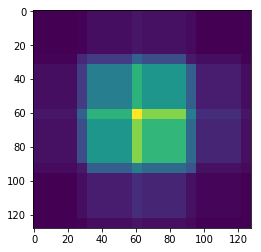

(0.9735685970661567, 1.0)


In [233]:
# Look at what the deconvolved result looks like for different shifts.
# I am imagining that, for some shifts at least, I manage to recover a better image than if I only had access to imA.

#for shiftYX in [[0,0], [10,10], [8,0]]:
for dx in [6]:#range(0,16):
    shiftYX = (dx,dx)
    imageAB = ForwardTransform2(objA, shiftYX)
    result = RL2(imageAB, shiftYX, iterations=10)
    plt.imshow(result)
    plt.show()

In [190]:
# Test whether we can identify the correct shift by trying different candidate shifts
bestScores = np.zeros((0,2))

def SubsampledMinimum(arr):
    pos = np.argmin(arr)
    if ((pos > 0) and (pos < (arr.shape[0]-1))):
        cl = arr[pos-1]
        c = arr[pos]
        cr = arr[pos+1]
        return pos + (cl-cr)/float(2*cl-4*c+2*cr)
    return pos
    
def GenerateJointDeconvolutionForComparison(imageAB, candidateShiftsYX):
    resultList = []
    for yxCand in candidateShiftsYX:
        # Deconvolve to obtain our best joint estimate of the object
        result = RL2(imageAB, yxCand)
        resultList.append([yxCand, result])
    return resultList

def GenerateSeparateDeconvolutionsForComparison(imageAB, dxCands):
    # Deconvolve the A and B images separately
    scores = np.zeros((0,2))
    resultA = RL(imageAB[0])
    resultB = RL(imageAB[1])
    # Build a list for comparison that involves all the candidate shifts of B
    resultList = []
    for dxCand in dxCands:
        candidateShiftYX = (0, dxCand)
        resultList.append([candidateShiftYX, resultA, ShiftObject(resultB, candidateShiftYX, -1)])
    return resultList

In [ ]:
trueShifts = range(32+1)
# Generate all the candidate result objects for different shifts
#jointDeconvResults = []
separateDeconvResults = []
for dxTrue in trueShifts:
    trueShiftYX = (0, dxTrue)
    imageAB = ForwardTransform2(objA, trueShiftYX)
    results = GenerateJointDeconvolutionForComparison(imageAB, dxCands=range(32))
    jointDeconvResults.append(results)
    results = GenerateSeparateDeconvolutionsForComparison(imageAB, dxCands=range(32))
    separateDeconvResults.append(results)    

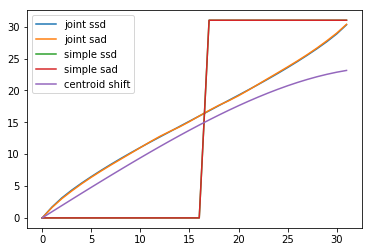

In [188]:
def Centroid(im):
    result = scipy.ndimage.measurements.center_of_mass(im)
    return result[1]

# Evaluate the result objects to compute the estimated shifts
bestScores = []
for dxTrue in trueShifts:
    trueShiftYX = (0, dxTrue)
    imageAB = ForwardTransform2(objA, trueShiftYX)
    scores = np.zeros((0,6))
    for (candidateShiftYX, thisObj) in jointDeconvResults[dxTrue]:
        # Generate the image that would be obtained from this recovered object
        candidateImage = ForwardTransform2(thisObj, candidateShiftYX)
        # Evaluate the match using SSD
        ssdScore = np.sum((candidateImage - imageAB)**2)
        # Evaluate the match using SAD
        sadScore = np.sum(np.abs(candidateImage - imageAB))
        thisRow = np.array([[candidateShiftYX[1], ssdScore, sadScore, 0, 0, 0]])
        scores = np.append(scores, thisRow, axis=0)
    i = 0
    for (candidateShiftYX, thisObjA, thisObjB) in separateDeconvResults[dxTrue]:
        # Evaluate the match using SSD
        ssdScore = np.sum((thisObjA - thisObjB)**2)
        # Evaluate the match using SAD
        sadScore = np.sum(np.abs(thisObjA - thisObjB))
        scores[i,3] = ssdScore
        scores[i,4] = sadScore
        i = i+1
    centroidShift = Centroid(separateDeconvResults[dxTrue][0][2]) - Centroid(separateDeconvResults[dxTrue][0][1])
    bestScores.append([dxTrue, SubsampledMinimum(scores[:,1]), SubsampledMinimum(scores[:,2]), SubsampledMinimum(scores[:,3]), SubsampledMinimum(scores[:,4]), centroidShift])
    
bestScores = np.array(bestScores)
plt.plot(bestScores[:,0], bestScores[:,1], label='joint ssd')
plt.plot(bestScores[:,0], bestScores[:,2], label='joint sad')
plt.plot(bestScores[:,0], bestScores[:,3], label='simple ssd')
plt.plot(bestScores[:,0], bestScores[:,4], label='simple sad')
plt.plot(bestScores[:,0], bestScores[:,5], label='centroid shift')
plt.legend()
plt.show()
# Note that the centroid does not work correctly in this case because I do a circular roll.
# It will be interesting to look at if I get to a point where I do a proper translation rather than a circular roll

OK so, as I had hoped, the results are massively better if I do a joint recovery and look for the best-matching shift.

For now I think I have proved the basic point to myself that the block artefacts in the native focal plane will completely screw a PIV analysis, and that I do seem to have a plausible (if slow) solution to the issue.

It's pretty slow though (even though I only need a small number of RL iterations). A 2D velocity search would be even slower, of course. The feasibility of this will depend a lot on whether there is a more efficient way to do a joint optimization of the object and the velocity. That would require considerably more investigation and trialling.

-> But actually: I can optimize over the velocity but, for a given velocity field, use the RL to solve for the object. That will still be slow, but it should be manageable I think - and aided by the fact that there should be only weak coupling between the different velocity values. Also, from what I have seen so far, it looks as if the velocity solution is a mostly convex problem.

With a full velocity field, the one thing I will need to think about is how to handle the IWs etc:

(1) Adjacent IWs will have different flows, but I need to generate a smoothly transformed object. I can decide to define the velocity in the B frame or the A frame. If I define in the A frame then each A frame voxel moves to a (noninteger) location in the B frame and its intensity is spread appropriately between the overlapping destination voxels. That will conserve energy, and I think any risk of "gaps" is very small (any scenario that gives that is unlikely to represent a sensible flow field anyway I think). If I define it in the B frame then I don't have voids but won't conserve energy, which I think would be a big problem for the RL.

(2) I worry slightly that by interpolating I am blurring out the object and therefore compromising the calculation. However, I think in principle any concern there can be overcome by increasing the sampling of the object we are trying to recover.

(3) A pertinent, and I suspect hard-to-answer, question is whether the recovered flow vector is definitely the correct solution or might be a false local (or even global) minimum. I suspect that both with light field and with heavily compressive type modalities, there might be quite a lot of flexibility in recovered objects that satisfy the constraints. But would there really be a different object *and a different associated flow field* that satisfies the constraints? To answer that question it really comes down to how thoroughly you can map out the space of possible flow fields. From what I have seen so far, it seems quite convex with one clear minimum. It's possible that's not so much the case with highly compressive measurements. (And what about our double RL...!?)

Note that as well as working with single-pixel imaging, this ought to permit tracking in compressed image files e.g. jpg, low-bitrate mpeg. (In discussion text I should include temporal coding e.g. Laura Waller FOM talk)

n.b. I should revisit the number of iterations I am using. Maximum value in the result array does gradually stabilize over iterations 10-40, even if visually I don't see a huge difference. I should look in more detail at how the image is converging, and think about number of iterations...

In [215]:
def ScoreShift(candidateShiftYX, imageAB):
    res = GenerateJointDeconvolutionForComparison(imageAB, [candidateShiftYX])
    obj = res[0][1]
    candidateImage = ForwardTransform2(obj, candidateShiftYX)
    # Evaluate the match using SSD
    ssdScore = np.sum((candidateImage - imageAB)**2)
    #print('return', ssdScore, 'for', candidateShiftYX)
    return ssdScore

actualShifts = [(10,4), (0,0), (-4,17), (2,-7)]
for actualShift in actualShifts:
    # Generate an image pair based on a chosen shift transform
    imageAB = ForwardTransform2(objA, actualShift)
    # Optimize to obtain the best-matching shift
    shift = scipy.optimize.minimize(ScoreShift, (0,0), args=(imageAB))
    print('shift', shift['x'], 'for actual shift', actualShift)

('shift', array([11.00006583,  5.35507403]), 'for actual shift', (10, 4))
('shift', array([0., 0.]), 'for actual shift', (0, 0))
('shift', array([-133.40275936,   16.81380401]), 'for actual shift', (-4, 17))
('shift', array([ 2.90987348, -8.3801063 ]), 'for actual shift', (2, -7))


In [227]:
# Repeat with some noise added.
# For the most part it seems surprisingly tolerant of noisy images,
# although I suppose the smearing over a lenslet footprint smooths out the noise quite a lot
for actualShift in actualShifts:
    # Generate an image pair based on a chosen shift transform
    imageAB = np.random.poisson(ForwardTransform2(objA, actualShift) * 15)
    # Optimize to obtain the best-matching shift
    shift = scipy.optimize.minimize(ScoreShift, (0,0), args=(imageAB))
    print('shift', shift['x'], 'for actual shift', actualShift)

('shift', array([10.88857709,  5.04209291]), 'for actual shift', (10, 4))
('shift', array([ 0.11184558, -0.00154154]), 'for actual shift', (0, 0))
('shift', array([-5.96857397,  0.85743904]), 'for actual shift', (-4, 17))
('shift', array([ 3.60202288, -7.96942834]), 'for actual shift', (2, -7))
